<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
Name = "Fatemeh Raeijian"
StudentId = "402203389"

# Introduction

Deep autoregressive models are sequence models, yet feed-forward (i.e. not recurrent); generative models, yet supervised. They are a compelling alternative to RNNs for sequential data, and GANs for generation tasks.

Moreover, a deep autoregressive model is merely a feed-forward model which predicts future values from past values.

However, you may think that the term **Autoregressive** is equivalent to **Deep Autoregressive**; But actually, it is not true! Autoregressive Linear Models like `ARMA` or `ARCH` have been used in statistics, econometrics and financial modelling for ages and are not **Deep**. In this exercise, we work with deep ones. 

## Mathematical Description
The mathematical foundation of autoregressive models is based on the chain rule of probability. We can factorize the joint distribution over the n-dimensions as:

$$p(x) = \prod_{i=1}^{n} p(x_i | x_1, x_2, …, x_{i-1}) = \prod_{i=1}^{n} p(x_i | x_{<i})$$

where $x_{<i} = [x_1, x_2, …, x_{i-1}]$ denotes the vector of random variables with index less than $i$.

## Advantages and Disadvantages
Autoregressive models are naturally strong generative models that constitute one of the current state-of-the-art architectures on likelihood-based image modeling, and are also the basis for large language generation models such as GPT3. Similar to the language generation, autoregressive models work on images by modeling the likelihood of a pixel given all previous ones. For instance, in the picture below, we model the pixel $x_i$ as a conditional probability distribution based on all previous (here blue) pixels (figure credit - [Aaron van den Oord et al.](https://arxiv.org/abs/1601.06759)):

### PIC

Learning these conditionals is often much simpler than learning the joint distribution $p(\mathbf{x})$ all together. However, disadvantages of autoregressive models include slow sampling, especially for large images, as we need height-times-width forward passes through the model. In addition, for some applications, we require a latent space as modeled in VAEs and Normalizing Flows. For instance, in autoregressive models, we cannot interpolate between two images because of the lack of a latent representation. 

## Some Architectures and Applications of Autoregressive Models

- `PixelCNN` by Google DeepMind was probably the first deep autoregressive model, and the progenitor of most of the other models below. Ironically, the authors spend the bulk of the paper discussing a recurrent model, PixelRNN, and consider PixelCNN as a “workaround” to avoid excessive computation. However, PixelCNN is probably this paper’s most lasting contribution.
- `PixelCNN++` by OpenAI is, unsurprisingly, PixelCNN but with various improvements.
- `WaveNet` by Google DeepMind is heavily inspired by PixelCNN, and models raw audio, not just encoded music. They had to pull a neat trick from telecommunications/signals processing in order to cope with the sheer size of audio (high-quality audio involves at least 16-bit precision samples, which means a 65,536-way-softmax per time step!)
- `Transformer`, a.k.a. the “attention is all you need” model by Google Brain is now a mainstay of NLP, performing very well at many NLP tasks and being incorporated into subsequent models like BERT.

# Section 0 : Install Pre-requirements

In [2]:
!pip install -q yfinance
!pip install --quiet pytorch-lightning>=1.4

# Section 1 : Load the Data

The process begins with data acquisition from Yahoo Finance and loading it into memory. Yahoo Finance is utilized for its extensive financial market data. The yfinance library, known for its efficient and Python-friendly approach, is used to download this data.

In [3]:
# Import necessary libraries here. You may add other libraries to suit your needs.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import random
from sklearn.preprocessing import MinMaxScaler


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(47)

# Set up plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf

# Define the list of tech stocks for analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up the start and end times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Download stock data and assign it to global variables
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

# Define the list of companies and their names
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Add company name to each dataframe
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

# Concatenate all company dataframes
df = pd.concat(company_list, axis=0)

# Display the last 10 rows of the dataframe
df.tail(10)

/home/fateme/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price                     Adj Close Close High  Low Open Volume company_name  \
Ticker                         AAPL  AAPL AAPL AAPL AAPL   AAPL                
Date                                                                           
2024-10-08 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-09 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-10 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-11 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-14 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-15 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-16 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-17 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-18 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   
2024-10-21 00:00:00+00:00       NaN   NaN  NaN  NaN  NaN    NaN       AMAZON   

Price                     Adj Close Close High  ...       Low Open Volume  \
Ticker                         GOOG  GOOG GOOG  ... MSFT MSFT MSFT   MSFT   
Date                                            ...                         
2024-10-08 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-09 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-10 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-11 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-14 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-15 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-16 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-17 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-18 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   
2024-10-21 00:00:00+00:00       NaN   NaN  NaN  ...  NaN  NaN  NaN    NaN   

Price                       Adj Close       Close        High         Low  \
Ticker                           AMZN        AMZN        AMZN        AMZN   
Date                                                                        
2024-10-08 00:00:00+00:00  182.720001  182.720001  183.089996  180.919998   
2024-10-09 00:00:00+00:00  185.169998  185.169998  185.850006  182.050003   
2024-10-10 00:00:00+00:00  186.649994  186.649994  188.130005  185.830002   
2024-10-11 00:00:00+00:00  188.820007  188.820007  189.929993  186.300003   
2024-10-14 00:00:00+00:00  187.539993  187.539993  189.830002  187.360001   
2024-10-15 00:00:00+00:00  187.690002  187.690002  188.410004  184.580002   
2024-10-16 00:00:00+00:00  186.889999  186.889999  187.779999  185.610001   
2024-10-17 00:00:00+00:00  187.529999  187.529999  188.940002  186.000000   
2024-10-18 00:00:00+00:00  188.990005  188.990005  190.740005  186.279999   
2024-10-21 00:00:00+00:00  189.070007  189.070007  189.460007  186.399994   

Price                            Open      Volume  
Ticker                           AMZN        AMZN  
Date                                               
2024-10-08 00:00:00+00:00  181.919998  26372100.0  
2024-10-09 00:00:00+00:00  182.820007  26343100.0  
2024-10-10 00:00:00+00:00  187.130005  27785000.0  
2024-10-11 00:00:00+00:00  186.630005  25751600.0  
2024-10-14 00:00:00+00:00  189.779999  22614400.0  
2024-10-15 00:00:00+00:00  187.630005  32178900.0  
2024-10-16 00:00:00+00:00  187.050003  23456800.0  
2024-10-17 00:00:00+00:00  188.220001  25039400.0  
2024-10-18 00:00:00+00:00  187.149994  37379700.0  
2024-10-21 00:00:00+00:00  188.080002  24120744.0  

[10 rows x 25 columns]

# Section 2 : Statistical Analysis

The `.describe()` function generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution, excluding `NaN` values. It can analyze both numeric and object series, as well as DataFrame column sets of mixed data types. The output varies based on the input data.

Use this function to generate a concise statistical summary of one of the stocks.

In [3]:
##### Exercise 1: Statistical summary #####
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,180.662302,182.117897,179.331151,180.828413,180.365848,5.747729e+07
std,9.469072,9.330296,9.381675,9.320131,9.396184,1.720107e+07
min,159.369995,161.050003,159.350006,160.100006,159.249985,2.404830e+07
25%,173.110004,174.307499,171.874996,173.544998,172.997765,4.688845e+07
50%,180.379997,182.079994,178.440002,180.640007,180.048973,5.353515e+07
75%,189.277496,189.990005,187.652500,189.317501,188.879906,6.248945e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


Now, using the `.info()` method, provide a concise summary of the DataFrame. This includes information such as:
1. The number of entries (rows)
2. The number of columns
3. The names of the columns
4. The number of non-null values in each column
5. The data type of each column (e.g., integer, float, object)


In [4]:
##### Exercise 2: DataFrame summary #####
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-03-29 to 2024-03-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Adj Close     252 non-null    float64
 5   Volume        252 non-null    int64  
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


The closing price, the last traded price during a regular trading day, is a key benchmark for tracking stock performance.
Let's visualize the historical closing prices for our list of companies.

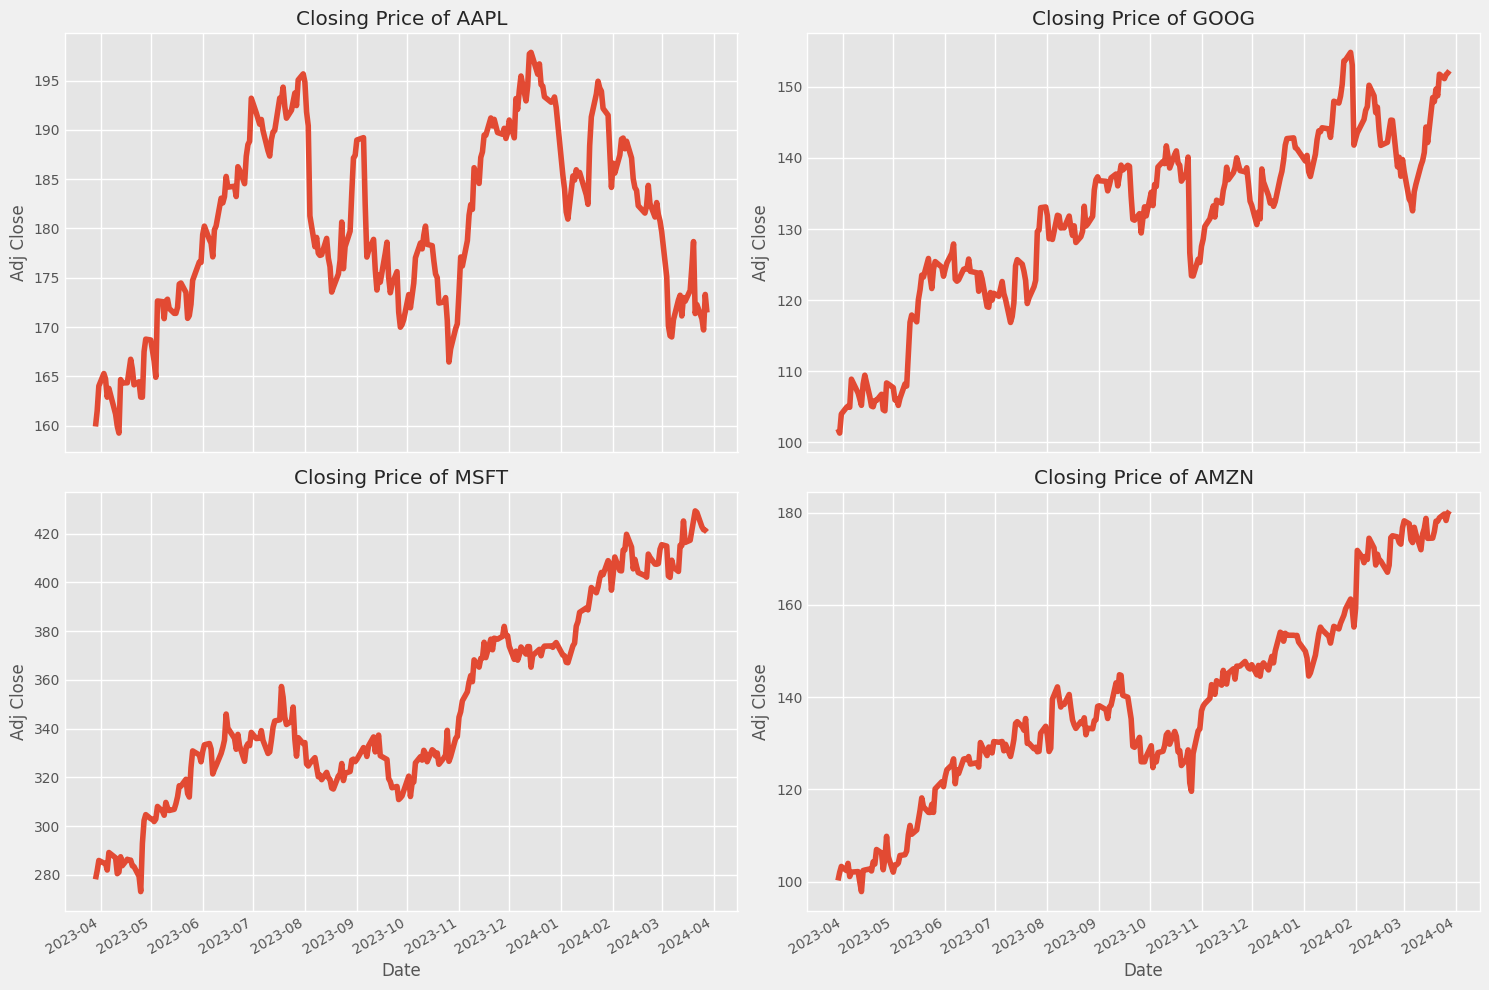

In [5]:
##### Exercise 3: Visualize the historical closing prices #####
# Set figure size and style
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')

# Loop through each company and plot their closing price
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)  # Create subplot for each company
    company['Adj Close'].plot()  # Plot the adjusted close price
    plt.ylabel('Adj Close')  # Label the y-axis
    plt.title(f"Closing Price of {tech_list[i - 1]}")  # Set title of the plot
    plt.grid(True)  # Add grid for better visualization
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis to show only year and month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set x-axis major ticks on a monthly basis
    plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

plt.tight_layout()

Volume refers to the number of shares traded during a certain period, often a day. It's a key metric for technical traders.
Let's visualize the daily trading volume for our list of companies.

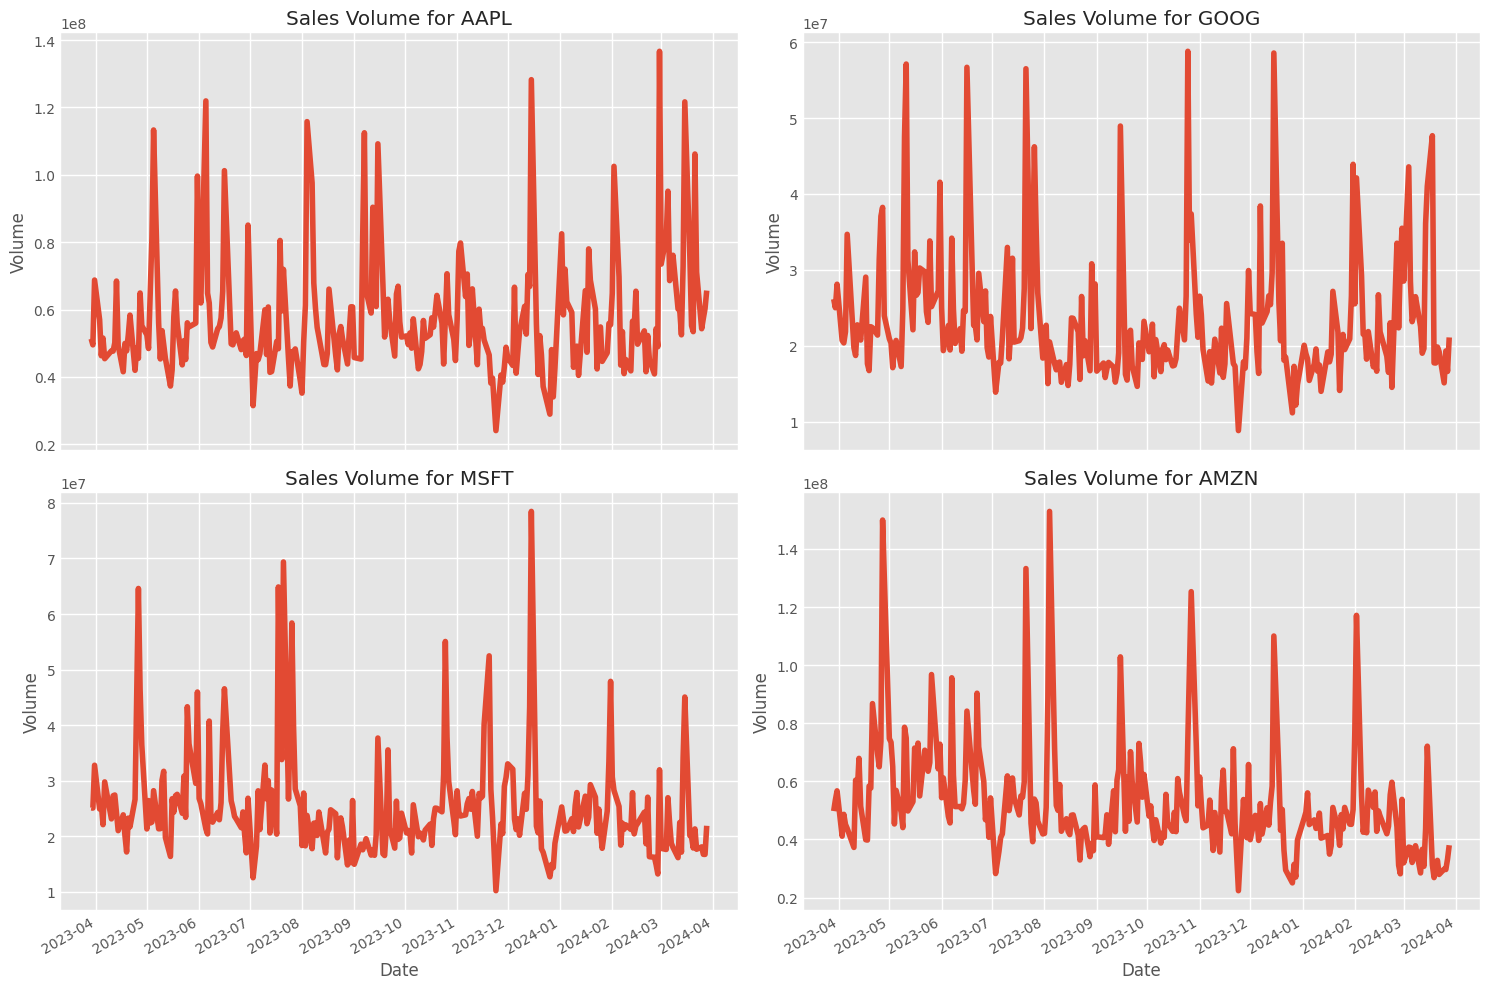

In [6]:
##### Exercise 4: Visualize the daily trading volume #####
# Set figure size and style
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')

# Loop through each company and plot their trading volume
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)  # Create subplot for each company
    company['Volume'].plot()  # Plot the trading volume
    plt.ylabel('Volume')  # Label the y-axis
    plt.title(f"Sales Volume for {tech_list[i - 1]}")  # Set title of the plot
    plt.grid(True)  # Add grid for better visualization
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis to show only year and month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set x-axis major ticks on a monthly basis
    plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

plt.tight_layout()

A stock moving average (MA) is a widely used technical indicator in financial analysis that helps smooth out price trends by filtering out the noise from random short-term price fluctuations. It is calculated by taking the arithmetic mean of a given set of prices over a specified period.

The moving average can be of different types, such as Simple Moving Average (SMA) and Exponential Moving Average (EMA). SMA is calculated by taking the arithmetic mean of a given set of prices over a specified period. On the other hand, EMA places greater weight on more recent prices than older ones over the time period.

Here, you should calculate and plot the 10, 20, and 50-day moving averages along with the adjusted close price for each company. The moving averages are calculated using the `rolling` method, which applies a function (in this case, mean) to a rolling window of data. The plots provide a visual representation of the stock price trends over time.

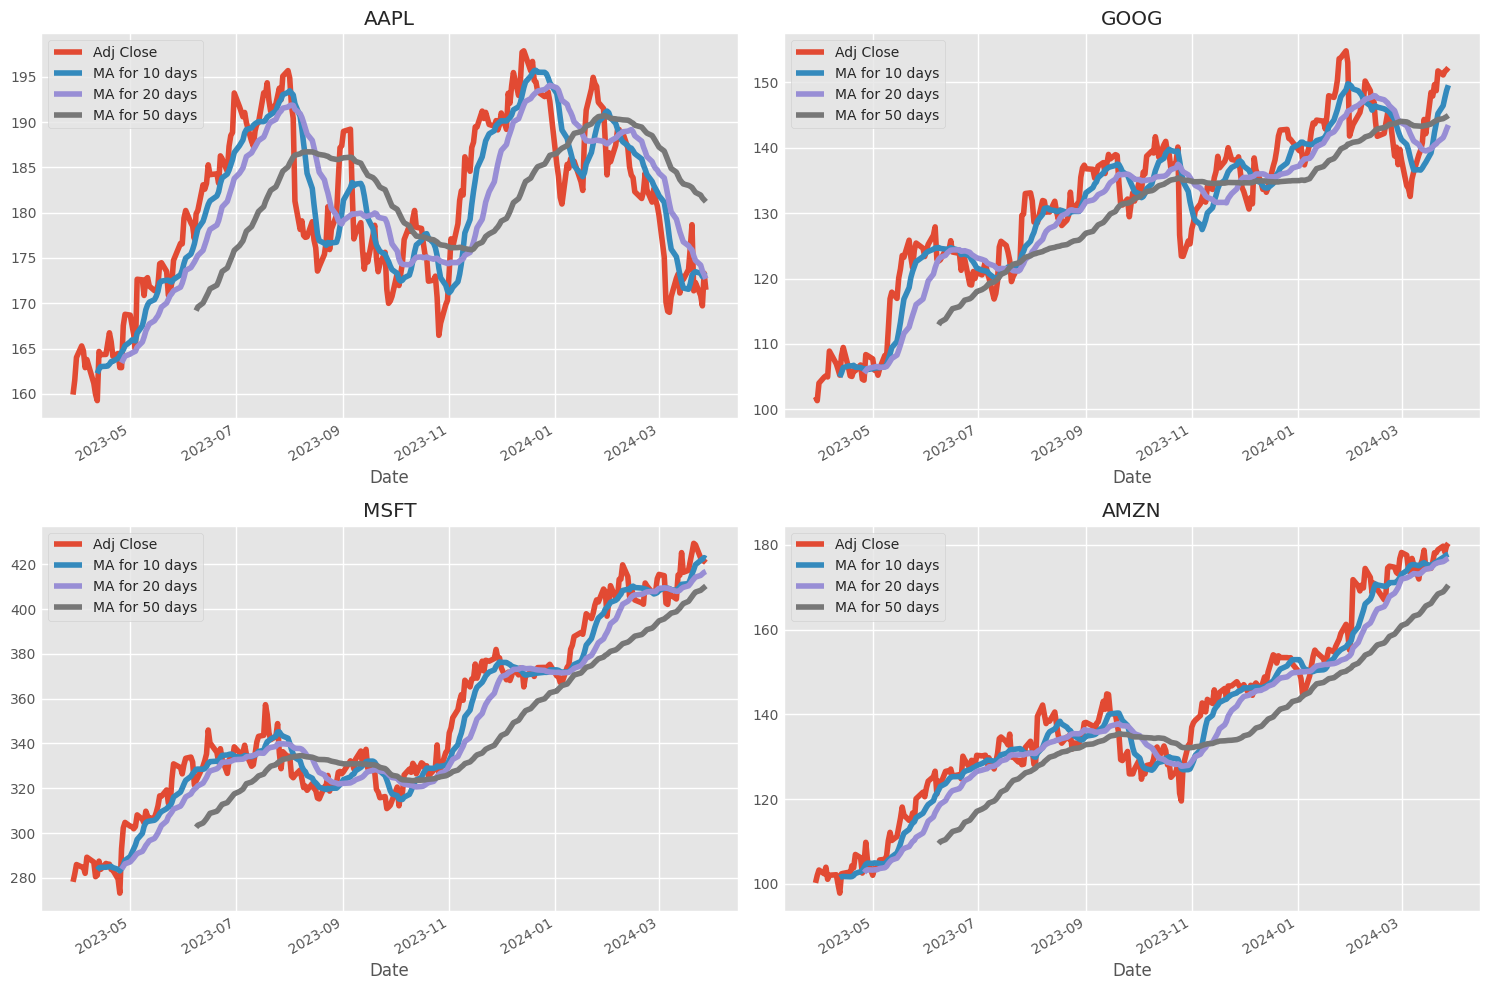

In [7]:
# Define moving average days
ma_day = [10, 20, 50]

##### Exercise 5: Calculate and plot the 10, 20, and 50-day moving averages along with the adjusted close price #####
# Calculate moving averages for each company
for ma in ma_day:
    for company in company_list:
        company[f"MA for {ma} days"] = company['Adj Close'].rolling(ma).mean()

# Create subplots for each company
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot adjusted close price and moving averages for each company
for i, company in enumerate(company_list):
    company[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(tech_list[i])

plt.tight_layout()


**Question:** Which moving average is the best choice for predicting the trends? Justify your answer.

Ans: As apparent from the above illustartions, the best values to measure the moving average is the 10-days avergae because we still capture trends in the data without much of the noise.

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve daily returns for all stocks. We'll use `pct_change` to find the percent change for each day.

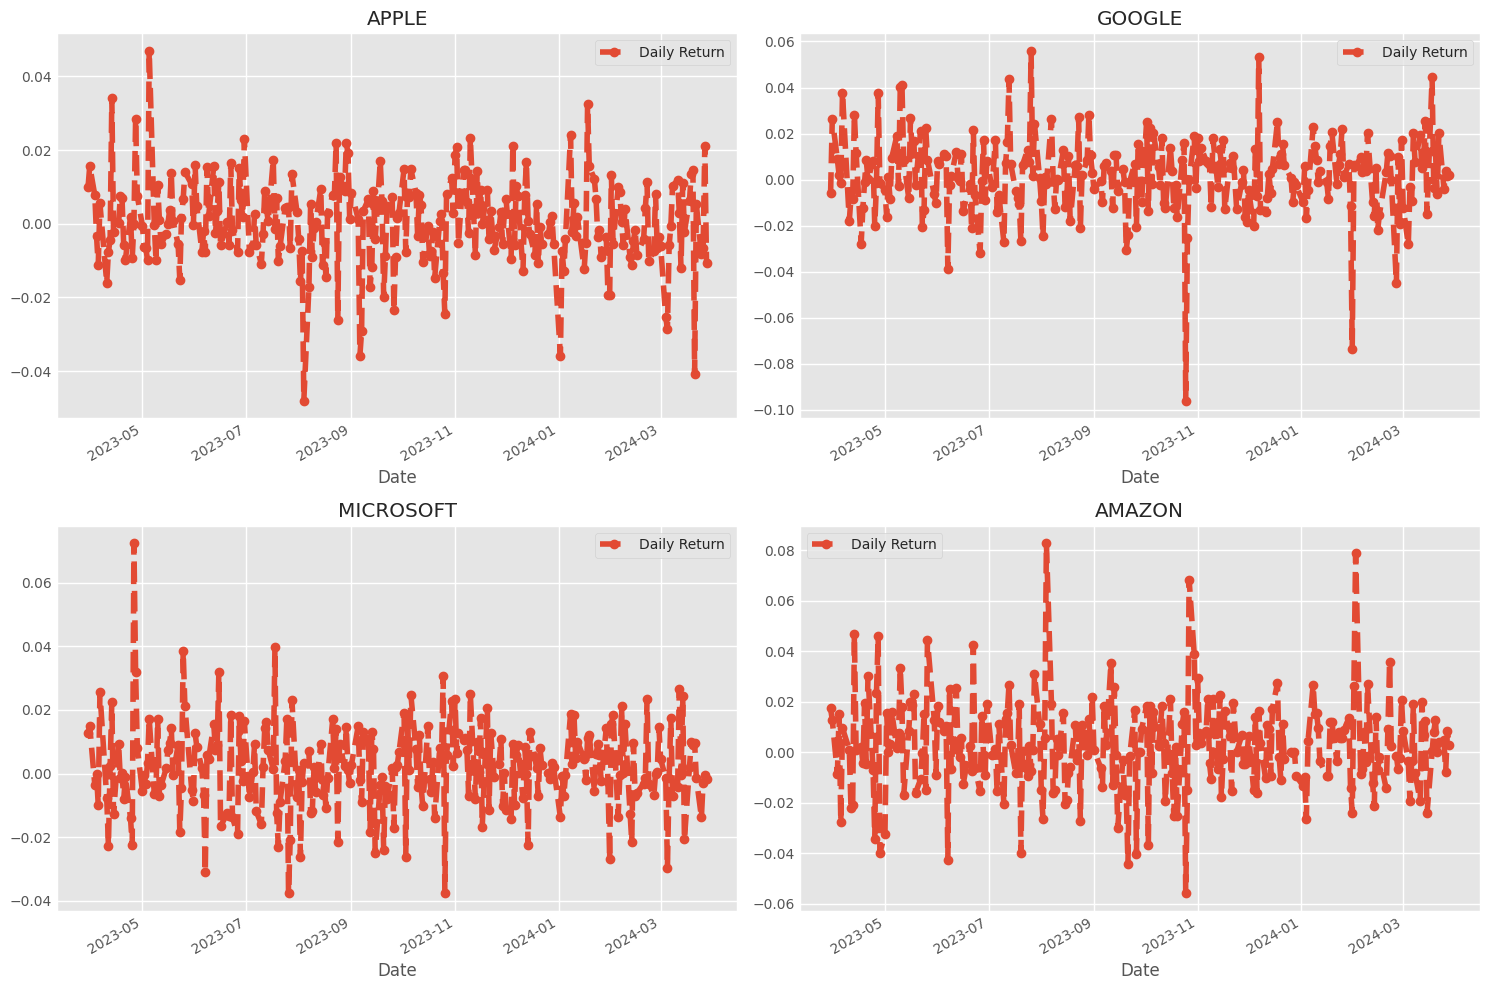

In [8]:
##### Exercise 6: Plot the daily return precentages #####
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Now let's get an overall look at the daily returns by creating a histogram for the `Daily Return` of each company in the `company_list`.

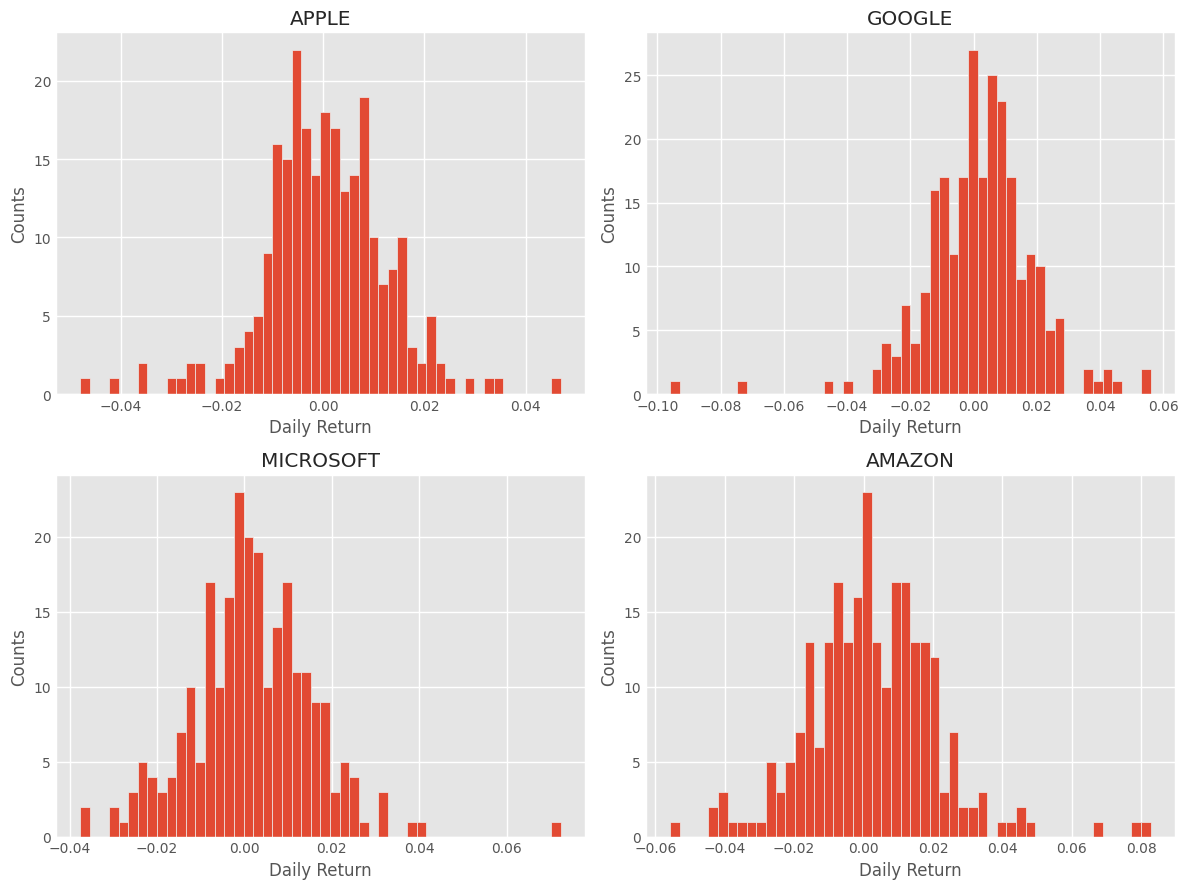

In [9]:
##### Exercise 7: Plot the histogram of daily returns #####
# Set figure size
plt.figure(figsize=(12, 9))

# Loop through each company and plot a histogram of their daily returns
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)  # Create subplot for each company
    company['Daily Return'].hist(bins=50)  # Plot histogram of daily returns
    plt.xlabel('Daily Return')  # Label the x-axis
    plt.ylabel('Counts')  # Label the y-axis
    plt.title(f'{company_name[i - 1]}')  # Set title of the plot

plt.tight_layout()  # Adjust layout for better visualization

## Correlation between different stocks closing prices

Correlation is a statistical measure that quantifies the degree of relationship between two variables. It provides an indication of how changes in one variable are associated with changes in another. The correlation coefficient ranges between -1.0 and +1.0. A correlation of +1.0 indicates a perfect positive correlation, meaning that both variables move in the same direction together. A correlation of -1.0 indicates a perfect negative correlation, meaning that the variables move in opposite directions. If the correlation is 0, it means there is no relationship between the variables. However, it's important to note that correlation does not imply causation. Even if two variables are correlated, it does not mean that changes in one variable are causing changes in another. There could be a third factor influencing both variables.

In the context of stock analysis, suppose we are interested in examining the returns of all the stocks in our list. To facilitate this, we can construct a DataFrame that consolidates the `Adj Close` columns from each of the individual stock dataframes. This will provide us with a comprehensive view of the closing prices for all stocks, enabling more efficient comparative analysis.

In [10]:
# Get the closing prices for all stocks in the tech list
data = yf.download(tech_list, start=start, end=end)

# Select only the 'Adj Close' column for each stock
closing_df = data['Adj Close']

# Calculate the daily returns for each stock
tech_rets = closing_df.pct_change()

# Display the first few rows of the returns DataFrame
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-03-29,NaN,NaN,NaN,NaN
2023-03-30,0.009890,0.017456,-0.005692,0.012620
2023-03-31,0.015644,0.012647,0.026451,0.014962
2023-04-03,0.007702,-0.008520,0.008750,-0.003711
2023-04-04,-0.003250,0.015038,0.002002,-0.000174


Now we can compare the daily percentage return of all pairs to check how they are correlated.

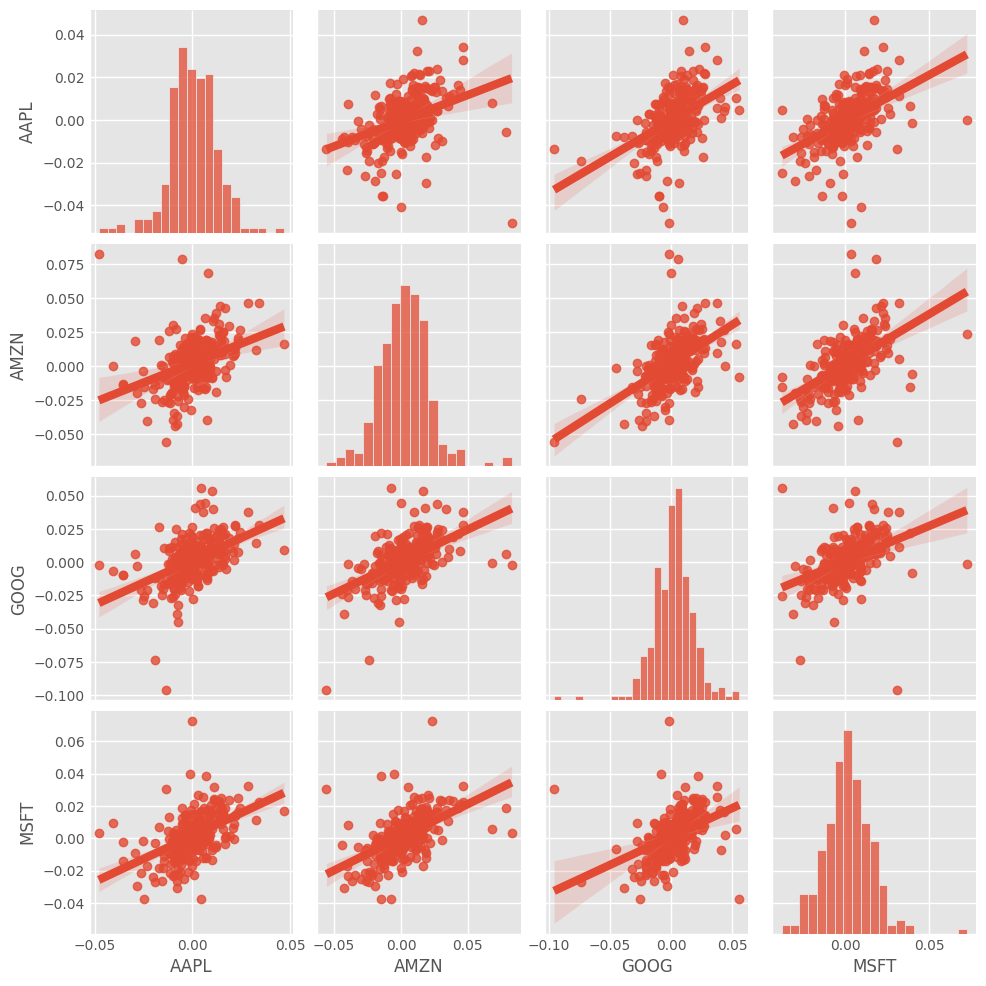

In [11]:
##### Exercise 8: Plot the correlation regression plot for all pairs #####
# Call pairplot on our DataFrame for an automatic visual analysis of all pairs
sns.pairplot(tech_rets, kind='reg')

**Question:** What implications might a linear relationship have for investment strategies?

Ans: A linear relationship occurs between the daily return values of two stocks when they are correlated. This, of course, does NOT indicate causation but might be caused by a common cause to both changes. Thus, if two stocks are positively correlated for a substantial amount of time, they will likely have similar returns in the near future.

Finally, Let's create two heatmaps: one for the correlation between the daily returns of the stocks and another for the correlation between the closing prices of the stocks. This provides a visual and numerical understanding of the relationships between different stocks.

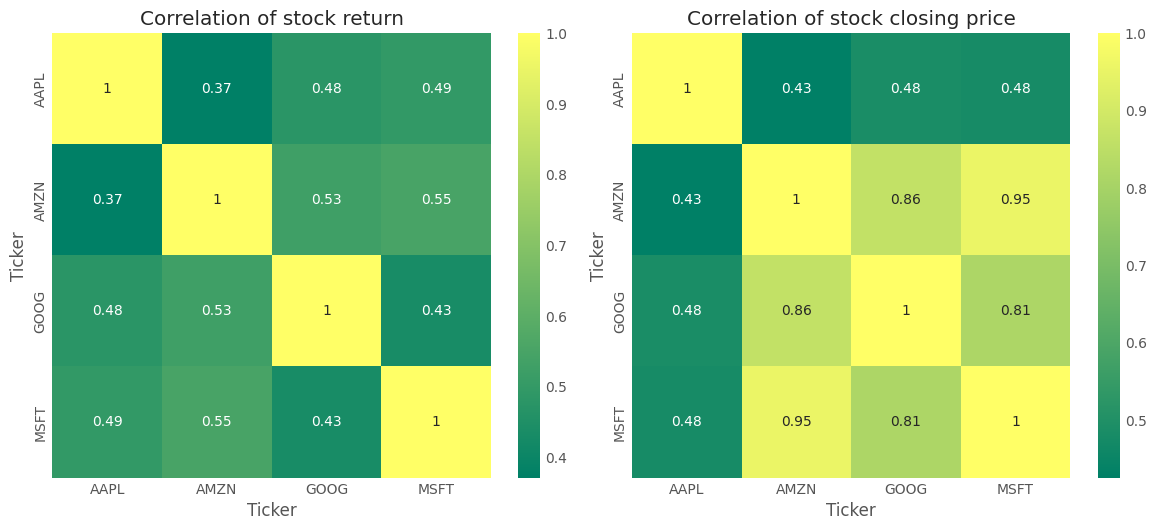

In [12]:
##### Exercise 9: Plot correlation heatmaps #####
# Set figure size
plt.figure(figsize=(12, 10))

# Create a heatmap to show the correlation between the daily returns of the stocks
plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

# Create a heatmap to show the correlation between the closing prices of the stocks
plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

# Adjust layout for better visualization
plt.tight_layout()

**Question:** Which pair has the strongest correlation of daily return stocks? What other interesting facts could be infered from the plots above?

Ans: Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# Predicting the closing price
In this section, we will try to predict the closing price of a stock using an LSTM model. Choose one stock and after visualizing the closing history, do any preprocessing you need and create a training data set.

In [13]:
##### Exercise 10: Download and display the head of a stock from Yahoo Finance #####
df = yf.download('AAPL', start='2012-01-01', end=end)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433828,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500645,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639427,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771557,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751303,394024400
...,...,...,...,...,...,...
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400


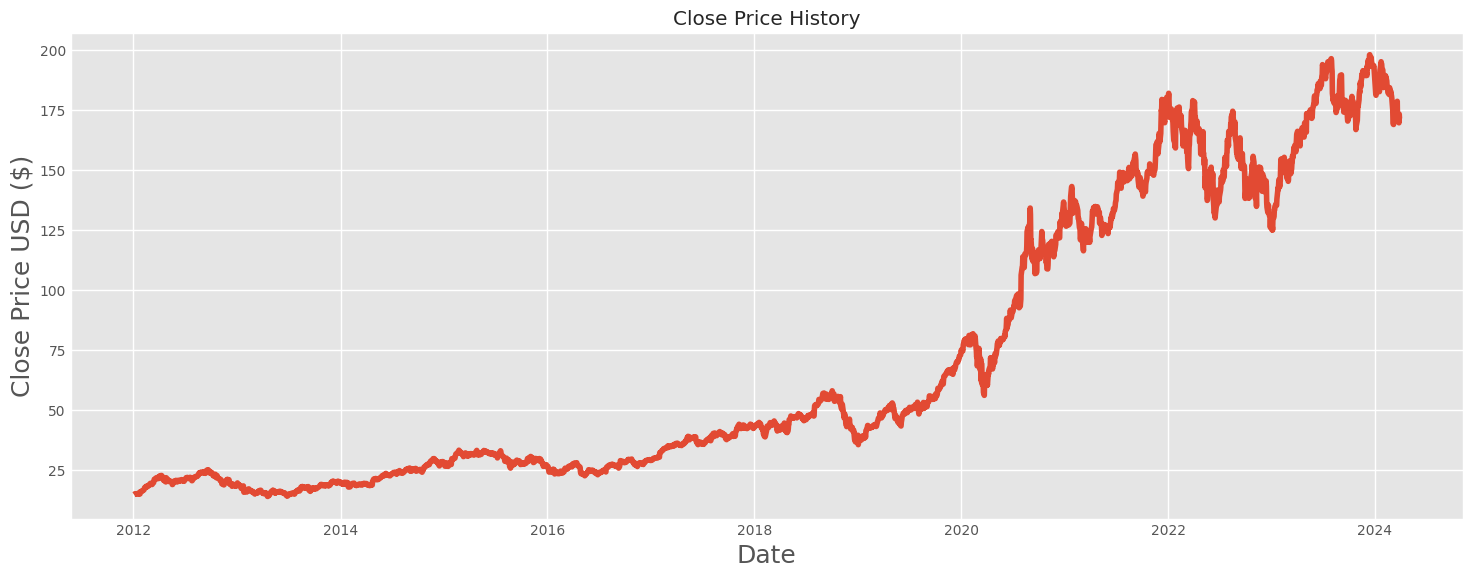

In [14]:
##### Exercise 11: Plot the closing price history of your stock #####
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [15]:
##### Exercise 12: Preparing the data (Use a 95-5 Train/Test ratio) #####
# Filter the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

print('Number of Training data points:', training_data_len)
#2926

Number of Training data points: 2926


In [16]:
##### Exercise 13: Scaling the data #####
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.8457884 ],
       [0.8653363 ],
       [0.85539942]])

In [17]:
##### Exercise 14: Creating the training and test data sets #####
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train_torch = torch.from_numpy(x_train).float().unsqueeze(-1)
y_train_torch = torch.from_numpy(y_train).float().unsqueeze(1)

# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array and then to PyTorch tensor
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test_torch = torch.from_numpy(x_test).float().unsqueeze(-1)  # add an extra dimension for input_size

Define your model here


In [59]:
# KERAS Model (ONLY FOR THE PURPOSE OF COMPARISON)
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2866/2866 [==============================] - 177s 60ms/step - loss: 0.0013


In [62]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE:', rmse)

5/5 [==============================] - 0s 42ms/step
RMSE: 3.767032820446734


In [73]:
##### Exercise 15: Define your model ######
# LSTM Model
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1,
                            num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size2, 25)
        self.fc2 = nn.Linear(25, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size1).to(x.device)

        out, _ = self.lstm1(x, (h0, c0))

        h1 = torch.zeros(self.num_layers, out.size(0), self.hidden_size2).to(x.device)
        c1 = torch.zeros(self.num_layers, out.size(0), self.hidden_size2).to(x.device)

        out, _ = self.lstm2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)

        return out

# Set parameters
num_epochs = 101
learning_rate = 0.05

input_size = 1
hidden_size1 = 32
hidden_size2 = 16
num_layers = 1
seq_length = x_train.shape[1]
output_size = 1

lstm = LSTM(input_size, hidden_size1, hidden_size2, num_layers, output_size)

# Loss and Optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [74]:
##### Exercise 16: Train the model #####
for epoch in range(num_epochs):
    outputs = lstm(x_train_torch)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train_torch)

    loss.backward()

    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08765
Epoch: 10, loss: 0.09457
Epoch: 20, loss: 0.09111
Epoch: 30, loss: 0.04143
Epoch: 40, loss: 0.00578
Epoch: 50, loss: 0.00218
Epoch: 60, loss: 0.00121
Epoch: 70, loss: 0.00048
Epoch: 80, loss: 0.00023
Epoch: 90, loss: 0.00012
Epoch: 100, loss: 0.00010


In [75]:
##### Exercise 17: Predict price values & Calcualte RMSE for Test set ######
lstm.eval()
with torch.no_grad():
    predictions = lstm(x_test_torch)
predictions = predictions.cpu().data.numpy()

predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE:', rmse)

RMSE: 2.8888576849973


<ipython-input-76-c25130c433f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


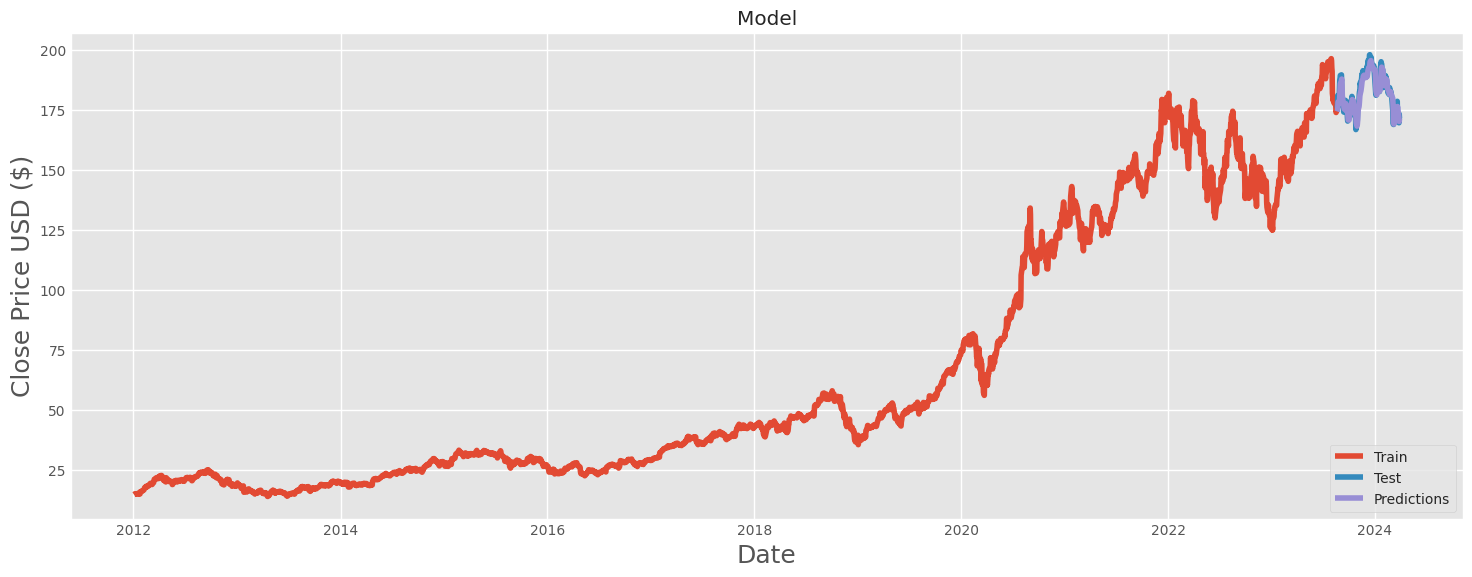

In [76]:
##### Exercise 18: Plot the entire closing price history & Compare it to your predictions ######
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [77]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-08-21,175.839996,174.436127
2023-08-22,177.229996,174.777618
2023-08-23,181.119995,176.004150
2023-08-24,176.380005,178.386612
2023-08-25,178.610001,178.281540
...,...,...
2024-03-22,172.279999,174.976074
2024-03-25,170.850006,172.913788
2024-03-26,169.710007,171.341888


**If you have any questions or need further clarification on any part of the exercise, please don’t hesitate to ask. Keep up the great work, and happy learning!**

## Bonus
You have the opportunity to develop an autoregressive model based on the concepts you learned in class and subsequently train it. Following that, you can compare its performance with that of the LSTM model

In [ ]:
#### Bonus ####

# New question

In [2]:
## Standard libraries
import os
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_30/57387670.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [11]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 58594642.29it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1508651.88it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13741364.61it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2417886.63it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



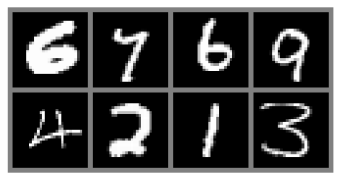

In [4]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [5]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically 
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)
        
        # Mask as buffer => it is no parameter but still a tensor of the module 
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])
        
    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [6]:
class VerticalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        
        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)
        
class HorizontalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        
        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)

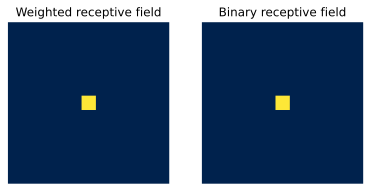

In [7]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads
    
    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, inp_img)

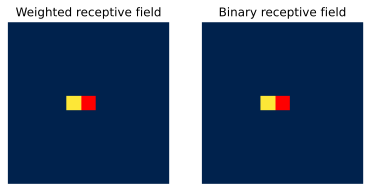

In [8]:
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

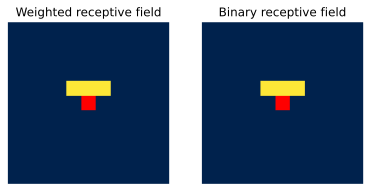

In [9]:
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

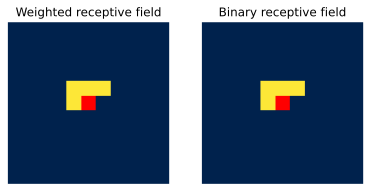

In [10]:
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

Layer 2


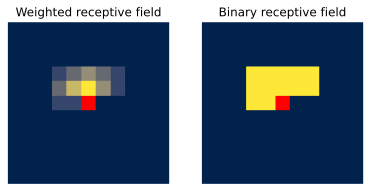

Layer 3


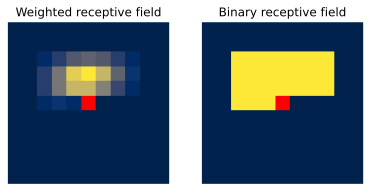

Layer 4


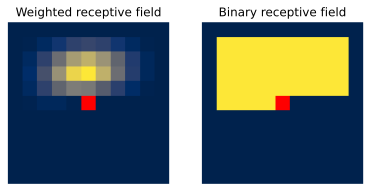

Layer 5


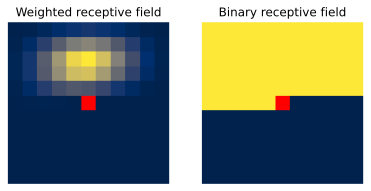

In [11]:
# Initialize convolutions with equal weight to all input pixels
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3,mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

# We reuse our convolutions for the 4 layers here. Note that in a standard network,
# we don't do that, and instead learn 4 separate convolution. As this cell is only for
# visualization purposes, we reuse the convolutions for all layers.
for l_idx in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, horiz_img)

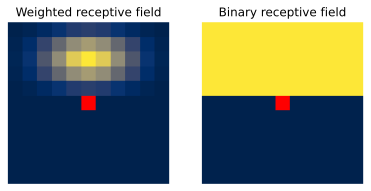

In [12]:
show_center_recep_field(inp_img, vert_img)

In [13]:
del inp_img, horiz_conv, vert_conv

In [14]:
class GatedMaskedConv(nn.Module):
    
    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)
    
    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)
        
        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack
        
        return v_stack_out, h_stack_out

In [15]:
class PixelCNN(pl.LightningModule):
    
    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()
        
        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)
        
        self.example_input_array = train_set[0][0][None]
        
    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1 
        
        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))
        
        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out
    
    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()
        
    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill 
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:]) 
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])                             
        self.log('train_bpd', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)
        
    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)

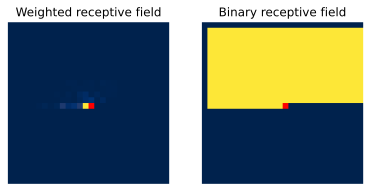

In [16]:
test_model = PixelCNN(c_in=1, c_hidden=64)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [17]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join('../saved_model', "PixelCNN"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=3, 
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                            
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join('../saved_model', "PixelCNN.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)
    
    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [ ]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

In [29]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


  0%|          | 0/28 [00:00<?, ?it/s]

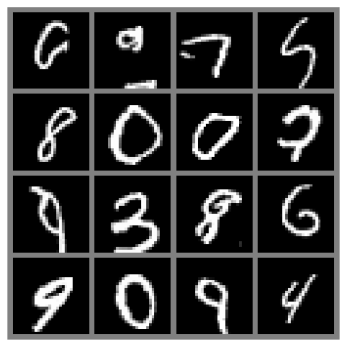

In [30]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

  0%|          | 0/64 [00:00<?, ?it/s]

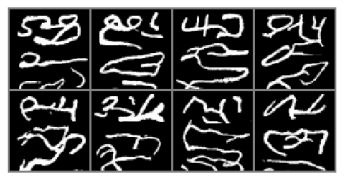

In [31]:
pl.seed_everything(1)
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

Original image and input image to sampling:


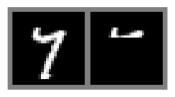

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


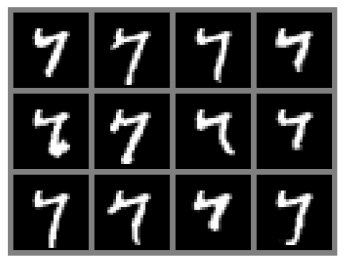

Original image and input image to sampling:


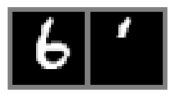

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


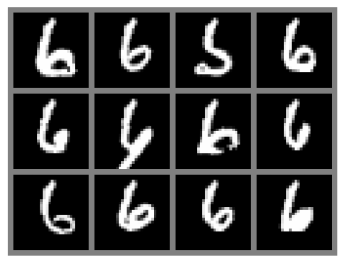

Original image and input image to sampling:


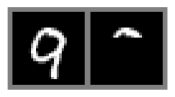

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


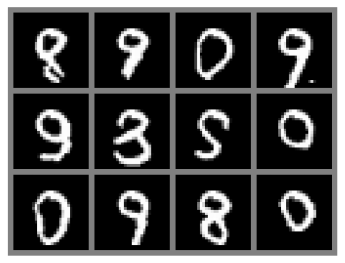

In [32]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)